In [ ]:
# Loading libraries
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import datetime as dt
from datetime import time
from datetime import timedelta

In [ ]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading datasets
train_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTrain.csv", parse_dates=["trans_date_trans_time"])
test_df = pd.read_csv("/content/drive/MyDrive/CFG_Project/fraudTest.csv", parse_dates=["trans_date_trans_time"])

In [ ]:
# merging pre-split training and test datasets into one dataframe
df = train_df.append(test_df, ignore_index=True)

In [ ]:
#Removing irrelevant variables

irrelevantVar_list = ['Unnamed: 0',
                      "first",
                      "last", 
                      "street", 
                      "zip",
                      "lat",
                      "job",
                      "long",
                      "cc_num", 
                      "unix_time",
                      "trans_num", 
                      "city",
                      "merchant",
                      "merch_lat",
                      "merch_long"]

df.drop(irrelevantVar_list, axis=1, inplace=True)

In [ ]:
# Here I am applying the pre-processing protocol developed by Juliana to test whether 
# by using this technique the logistic regression model yields better results

#Encoding variables

##1 - Business hours / Non business hours

#Standardize variable definitions(mixed two styles of variable definitions)

### Creating a column for business_hour with zero as default
df["business_hour"] = int(0)

###Considering business hours between 8:00-19:00
start = dt.datetime.strptime("08:00:00", "%H:%M:%S").time()
end = dt.datetime.strptime("19:00:00", "%H:%M:%S").time()

###Defining a mask for the query that catches data within the defined range
businessHour_mask = df["trans_date_trans_time"].dt.time.between(start, end)

###Setting numbers that fit into encoding to 1
df["business_hour"][businessHour_mask] = 1

##2 - Weekdays / Weekends

### Defining weekdays bin, being weekdays from Monday to Friday (0-4) and weekends Saturday and Sunday (5-6). Weekdays will be labelled as 1 and weekends as 0
weekDay_list = [0,1,2,3,4]
weekEnd_list = [5,6]

###Creating a new column is_weekday

df["is_weekday"] = int(0)

###Applying the 
df["is_weekday"][df["trans_date_trans_time"].dt.weekday.isin(weekDay_list)] = 1
df["is_weekday"][df["trans_date_trans_time"].dt.weekday.isin(weekEnd_list)] = 0

###Dropping the original trans_date_trans_time column 
df.drop(['trans_date_trans_time'], axis=1, inplace=True)

##3 - Male / Female

###Defining 1 as male and 2 as female and replacing values
df["gender"].replace('F', 0, inplace=True)
df["gender"].replace('M', 1, inplace=True)


##4 - Numeric age

###Transforming date of birth into numeric age
yearCharacters = 4
currentYear = int(dt.datetime.now().strftime("%Y"))

df["dob"] = currentYear - df["dob"].str[:yearCharacters].astype(int)


##5 - Target Encoding merchant categories

###Getting the means for each category
merchantMeans_dict = df.groupby('category')['is_fraud'].mean().to_dict()

###Replacing the categorical labels with the means
df['category'] = df['category'].map(merchantMeans_dict)

##6 - Target Encoding states

###Getting the means for each state
statetMeans_dict = df.groupby('state')['is_fraud'].mean().to_dict()

###Replacing the categorical labels with the means
df['state'] = df['state'].map(statetMeans_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#Separating the data into train and test

##1 - Separating X and y
X = df.drop(["is_fraud", "Unnamed: 0"], axis=1)
y = df['is_fraud']

##2 - Splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y, random_state=100)

In [ ]:
# Defining the model
model = LogisticRegression()

In [ ]:
# Fitting the model
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Estabishing y_pred to use for the creation of a confusion matrix that evaluates the model

y_pred = model.predict(X_test)

In [ ]:
# Creating a confusion matrix as an array

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[368411,    138],
       [  1930,      0]])

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9944180371896922
Precision: 0.0
Recall: 0.0


Text(0.5, 257.44, 'Predicted label')

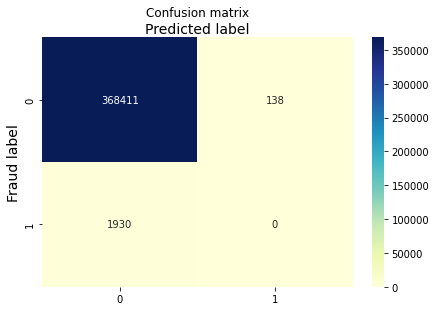

In [ ]:
# Showing confusion matrix as a heatmap
# Defining classes' names
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Creating heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Fraud label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)

After applying Juliana's pre-processing protocol I determined that the performance metrics of the logistic regression models continue to show overfitting. As observed in tests carried out so far, the model only correctly recognises genuine transactions since these comprise almost the entirety of the dataset. I will now proceed to test cross-validation as a method to reduce overfitting